## Rationale: Compare right atrium cells to sinus node cells

The purpose of this code is to compare the cells in common between right atrium (RA) and sinus node (SN) and see whether there is similarity between them.

## Load modules

In [1]:
import pandas as pd
import numpy as np
import scanpy
import matplotlib.pyplot as plt
import scipy.stats as pearsonr
import bulk2space
from tqdm import tqdm

## Load the input files

Loading the single cell data and meta from the right atrium and the sinus node.

The code below is an adapatation of what is done in "Bulk2space script.py"


In [2]:
# Right atrium data
input_data = bulk2space.utils.load_data(
    input_bulk_path="C:/Users/chelu/OneDrive - The University of Manchester/PhD OneDrive/Coding/Python Material/Bulk2space/Datasets/Halina Dobrzynski/Right Atrium/RA_human_bulk_cleaned.csv",
    input_sc_data_path="C:/Users/chelu/OneDrive - The University of Manchester/PhD OneDrive/Coding/Python Material/Bulk2space/Datasets/Halina Dobrzynski/Right Atrium/output/RA_human_from_mouse_sc_data.csv",
    input_sc_meta_path="C:/Users/chelu/OneDrive - The University of Manchester/PhD OneDrive/Coding/Python Material/Bulk2space/Datasets/Halina Dobrzynski/Right Atrium/output/RA_human_from_mouse_sc_celltype.csv",
    input_st_data_path="C:/Users/chelu/OneDrive - The University of Manchester/PhD OneDrive/Coding/Python Material/Bulk2space/Datasets/Halina Dobrzynski/Right Atrium/Empty_st_data.csv",
    input_st_meta_path="C:/Users/chelu/OneDrive - The University of Manchester/PhD OneDrive/Coding/Python Material/Bulk2space/Datasets/Halina Dobrzynski/Right Atrium/Empty_st_meta.csv",
)

new_ra_meta = pd.read_csv('reclustered cells RA.csv')

loading data......
load data done!


In [3]:
# Keep cells from new reclustering and add new Cell_type info to the sc_meta
input_data['input_sc_meta'] = input_data['input_sc_meta'][input_data['input_sc_meta']['Cell'].isin(new_ra_meta['Cell'])]
input_data['input_sc_meta'] = input_data['input_sc_meta'].merge(new_ra_meta[['Cell', 'Cell_type']], on='Cell', how = 'inner')
input_data['input_sc_meta'] = input_data['input_sc_meta'][['Cell', 'Cell_type_y']]
input_data['input_sc_meta'] = input_data['input_sc_meta'].rename(columns={'Cell_type_y':'Cell_type'})

# Apply the change to the sc_data as well
input_data['input_sc_data'] = input_data['input_sc_data'][new_ra_meta['Cell'].to_list()]

In [4]:
# Create a scanpy object for later integration
sc = scanpy.AnnData(input_data["input_sc_data"].T)
sc.obs = input_data["input_sc_meta"][["Cell_type"]]

        Cell          Cell_type
0        C_1  Endothelial cells
1        C_2        Pericytes 1
2        C_3        Fibroblasts
3        C_4  Endothelial cells
4        C_5        Fibroblasts
...      ...                ...
2739  C_2895        Fibroblasts
2740  C_2896               aCMs
2741  C_2897               aCMs
2742  C_2898        Fibroblasts
2743  C_2899               aCMs

[2744 rows x 2 columns]


In [5]:
# Sinus node data
sn_sc_data = pd.read_csv(
    "Sinus Node/output/SN_human_from_mouse_sc_data.csv")
sn_sc_meta = pd.read_csv(
    "reclustered cells SN.csv")

sn_sc_meta.head()

,Cell,Cell_type
0,C_1,Adipocytes 2
1,C_2,SN CMs
2,C_3,Macrophages
3,C_4,Adipocytes 2
4,C_5,SN CMs


## Correlation matrix

Calculate 200 marker genes of RA cells

In [7]:
sc = scanpy.AnnData(input_data["input_sc_data"].T)
sc.obs = input_data["input_sc_meta"][["Cell_type"]]
scanpy.tl.rank_genes_groups(sc, "Cell_type", method="wilcoxon")
marker_df = pd.DataFrame(sc.uns["rank_genes_groups"]["names"]).head(200)
marker = list(np.unique(np.ravel(np.array(marker_df))))

# Mean expression of 200 marker genes of input sc data
sc_marker = input_data["input_sc_data"].loc[marker, :].T
new_index = input_data['input_sc_meta']['Cell'].to_list()
input_data['input_sc_meta'] = input_data['input_sc_meta'].set_index('Cell')
sc_marker["Cell_type"] = input_data["input_sc_meta"]["Cell_type"]
sc_marker_mean = sc_marker.groupby("Cell_type")[marker].mean()

display(sc_marker_mean)

,ABCA6,ABCA8,ABCC9,ABI3,ABI3BP,ABLIM1,ACAA2,ACADL,ACADM,ACADVL,...,WAS,WASF2,WTIP,YBX1,YWHAB,YWHAQ,YWHAZ,ZBTB20,ZFHX3,ZFP36
Cell_type,,,,,,,,,,,,,,,,,,,,,
Endothelial cells,0.000275,0.021224,0.007119,0.391348,0.039059,0.849483,0.737263,0.631365,0.246312,0.215115,...,0.000000,0.621714,0.008591,1.824966,1.118277,0.901365,1.425575,0.313870,0.055190,0.845809
Fibroblasts,0.271860,0.260309,0.187008,0.000000,0.701755,0.422409,0.927325,0.627101,0.399555,0.694383,...,0.000000,0.518504,0.078022,1.470609,1.127693,0.962715,1.278079,1.248538,0.279236,1.260132
Leukocytes,0.000000,0.004331,0.000000,0.033897,0.002506,0.038899,0.307183,0.263043,0.244961,0.280320,...,0.155102,0.465583,0.007299,0.990878,0.391039,0.413963,0.791852,0.029365,0.075193,1.586783
Pericytes 1,0.188115,0.000000,2.937242,0.000000,0.084495,0.003926,0.640678,0.482138,0.207420,0.317274,...,0.000000,0.436461,0.002742,0.784391,1.562868,1.307063,1.716919,0.770603,0.353457,0.820264
Pericytes 2,0.124068,0.000000,2.584740,0.000000,0.097615,0.010725,0.404539,0.691818,0.384184,0.368572,...,0.000000,0.795732,0.000000,0.699718,1.163812,1.377486,1.461990,0.269261,0.183049,0.110628
SMCs,0.000000,0.000000,0.682618,0.000805,0.026020,0.037731,0.975955,0.515897,0.841320,0.626907,...,0.000000,0.355358,0.756867,1.309754,1.157853,1.449143,1.724979,0.460558,1.072170,1.432315
aCMs,0.000000,0.000000,0.000000,0.000000,0.019520,0.124431,1.602481,1.455733,1.181469,1.281331,...,0.000000,0.022471,0.025944,2.321063,0.192262,0.005383,0.341892,0.192068,0.000000,0.161153


Calculate 200 markers genes of SN cells

In [9]:
sn_sc_meta.index = list(sn_sc_meta["Cell"])
sn_sc_data_new = sn_sc_data.T
new_header = sn_sc_data_new.iloc[0]
sn_sc_data_new = sn_sc_data_new[1:]
sn_sc_data_new.columns = new_header
# ---------------------------------------------------------
# Added this line to fix code breaking at groupby
sn_sc_data_new = sn_sc_data_new.astype(float)
# ---------------------------------------------------------
common_markers = list(set(sn_sc_data_new.columns).intersection(set(marker)))
sn_sc_data_new = sn_sc_data_new[common_markers]
print(sn_sc_data_new.shape)
sn_sc_data_new["Cell_type"] = sn_sc_meta["Cell_type"]
sn_sc_marker_mean = sn_sc_data_new.groupby(["Cell_type"])[
    common_markers].mean()
sc_marker_mean = sc_marker_mean[common_markers]

(5357, 1152)


In [ ]:
# Run this cell only once to transpose the dataframes for plotting
sc_marker_mean = sc_marker_mean.T
sn_sc_marker_mean = sn_sc_marker_mean.T

Cell_type,Endothelial cells,Fibroblasts,Leukocytes,Mural cells 1,Mural cells 2,SMCs,aCMs
ZBTB20,0.313870,1.248538,0.029365,0.770603,0.269261,0.460558,0.192068
SHISA5,1.536778,1.490134,0.801377,1.233112,1.312440,0.353792,0.027818
ADCY4,0.398433,0.033716,0.003643,0.001181,0.015708,0.047101,0.000000
NAALAD2,0.018526,0.644165,0.000000,0.870547,0.461061,0.021950,0.000000
COX7C,0.240658,0.242858,0.170975,0.215835,0.158933,0.358278,0.785329
...,...,...,...,...,...,...,...
SRPX2,0.007768,0.345620,0.000000,0.218973,0.136277,0.036699,0.000000
FAM20C,0.000000,0.483036,0.000000,0.027364,0.000000,0.000000,0.031504
TSPAN15,0.223035,0.005166,0.031961,0.665937,1.180557,0.241123,0.000000
PECAM1,1.517345,0.011487,0.159649,0.000000,0.001037,0.008015,0.000000


100%|██████████| 7/7 [00:00<00:00, 455.25it/s]


Correlation between Endothelial cells and Adipocytes 1 = 0.22526288643273995
Correlation between Endothelial cells and Adipocytes 2 = 0.19118775256712595
Correlation between Endothelial cells and Endothelial cells = 0.2190224694639774
Correlation between Endothelial cells and Fibroblasts = 0.1813387261253657
Correlation between Endothelial cells and Macrophages = 0.18776965588011507
Correlation between Endothelial cells and Pacemaker CMs = 0.13583358491706687
Correlation between Endothelial cells and SN CMs = 0.13243713007079239
Correlation between Fibroblasts and Adipocytes 1 = 0.23021878989312666
Correlation between Fibroblasts and Adipocytes 2 = 0.20628048329739612
Correlation between Fibroblasts and Endothelial cells = 0.17285327189073035
Correlation between Fibroblasts and Fibroblasts = 0.2686993162851633
Correlation between Fibroblasts and Macrophages = 0.25342912384744487
Correlation between Fibroblasts and Pacemaker CMs = 0.1853030165233991
Correlation between Fibroblasts and S

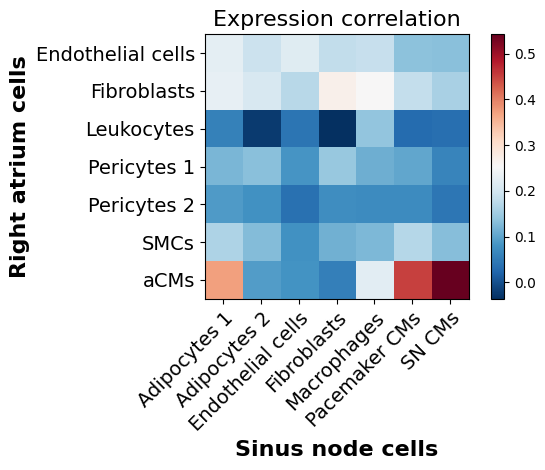

In [16]:
# Calculate correlation matrix
coeffmat = np.zeros(
    (sc_marker_mean.shape[1], sn_sc_marker_mean.shape[1]))
for i in tqdm(range(sc_marker_mean.shape[1])):
    for j in range(sn_sc_marker_mean.shape[1]):

        corrtest = pearsonr.pearsonr(
            sc_marker_mean[sc_marker_mean.columns[i]],
            sn_sc_marker_mean[sn_sc_marker_mean.columns[j]],
        )
        coeffmat[i, j] = corrtest[0]
        print('Correlation between', sc_marker_mean.columns[i], 'and', sn_sc_marker_mean.columns[j], '=', corrtest[0])

rf_ct = list(sc_marker_mean.columns)
sn_ct = list(sn_sc_marker_mean.columns)

# plot
fig, ax = plt.subplots()
im = ax.imshow(coeffmat, cmap="RdBu_r")
ax.set_xticks(np.arange(len(sn_ct)))
ax.set_xticklabels(sn_ct, fontsize = 14)
ax.set_yticks(np.arange(len(rf_ct)))
ax.set_yticklabels(rf_ct, fontsize = 14)
plt.xlabel("Sinus node cells", fontsize = 16, fontweight = 'bold')
plt.ylabel("Right atrium cells", fontsize = 16, fontweight = 'bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
ax.set_title("Expression correlation", fontsize = 16)
fig.tight_layout()
plt.savefig('RA vs SN Correlation map.png', dpi =600)